In [1]:
# ### 📌 Step 1: Install and import required libraries
!pip install tensorflow scikit-learn matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split


In [2]:
# ###  Step 2: Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

# Reduce data size for quick experimentation
x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=10000, stratify=y_train)
x_test, _, y_test, _ = train_test_split(x_test, y_test, train_size=2000, stratify=y_test)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# ###  Step 3: Define encoder model (ResNet50 backbone)
def create_encoder():
    base_model = keras.applications.ResNet50(include_top=False, input_shape=(32,32,3), pooling='avg')
    base_model.trainable = False
    inputs = keras.Input(shape=(32, 32, 3))
    features = base_model(inputs, training=False)
    return keras.Model(inputs, features, name="encoder")


In [5]:
# ###  Step 4: Add projection head for supervised contrastive learning
def add_projection_head(encoder):
    inputs = encoder.input
    features = encoder.output
    projection = layers.Dense(128, activation='relu')(features)
    projection = layers.Dense(64)(projection)
    return keras.Model(inputs, projection, name="encoder_with_projection")


In [6]:
# ###  Step 5: Define supervised contrastive loss function
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        labels = tf.cast(labels, dtype=tf.int32)
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.matmul(feature_vectors_normalized, feature_vectors_normalized, transpose_b=True)
        logits /= self.temperature
        mask = tf.equal(tf.expand_dims(labels, 1), tf.expand_dims(labels, 0))
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.cast(mask, tf.float32), logits=logits)
        return tf.reduce_mean(loss)


In [7]:
# ###  Step 6: Train encoder with supervised contrastive loss
encoder = create_encoder()
contrastive_model = add_projection_head(encoder)
contrastive_model.compile(optimizer='adam', loss=SupervisedContrastiveLoss())

history_contrastive = contrastive_model.fit(x_train, y_train, epochs=20, batch_size=128)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 479ms/step - loss: 66.6050
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 467ms/step - loss: 66.6740
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - loss: 66.5008
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - loss: 66.3688
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 466ms/step - loss: 66.8712
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 482ms/step - loss: 65.7879
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 467ms/step - loss: 66.7094
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 466ms/step - loss: 66.3837
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 474ms/step - loss: 67.1709
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 480ms/step - loss: 66.2815
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 485ms/step - loss: 66.3257
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - loss: 66.2563
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - loss: 66.3012
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 469ms

In [8]:
# ###  Step 7: Train classifier using softmax loss for comparison
def create_softmax_model():
    encoder = create_encoder()
    inputs = encoder.input
    features = encoder.output
    outputs = layers.Dense(10, activation='softmax')(features)
    return keras.Model(inputs, outputs)

softmax_model = create_softmax_model()
softmax_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_softmax = softmax_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=128)


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 632ms/step - accuracy: 0.1227 - loss: 2.8737 - val_accuracy: 0.1815 - val_loss: 2.2300
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 616ms/step - accuracy: 0.2122 - loss: 2.1968 - val_accuracy: 0.2300 - val_loss: 2.1240
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 548ms/step - accuracy: 0.2317 - loss: 2.1356 - val_accuracy: 0.2505 - val_loss: 2.0702
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 584ms/step - accuracy: 0.2525 - loss: 2.0716 - val_accuracy: 0.2220 - val_loss: 2.0895
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 596ms/step - accuracy: 0.2611 - loss: 2.0639 - val_accuracy: 0.2750 - val_loss: 2.0067
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 614ms/step - accuracy: 0.2838 - loss: 2.0218 - val_accuracy: 0.2825 - val_loss: 2.0013
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 78s 556ms/step - accuracy: 0.2842 - loss: 1.9940 - val_accuracy: 0.3120 - val_loss: 1.9801
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 596ms/step - accuracy: 0.2841 - loss: 1.9911 - val_accu

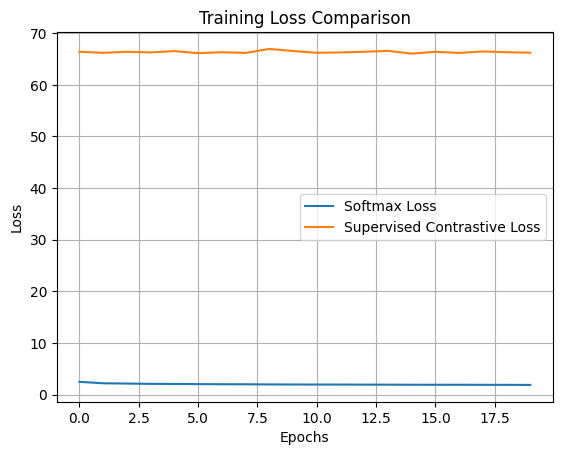

In [9]:
# ### 📌 Step 8: Plot training loss curves for both models
plt.plot(history_softmax.history['loss'], label="Softmax Loss")
plt.plot(history_contrastive.history['loss'], label="Supervised Contrastive Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step


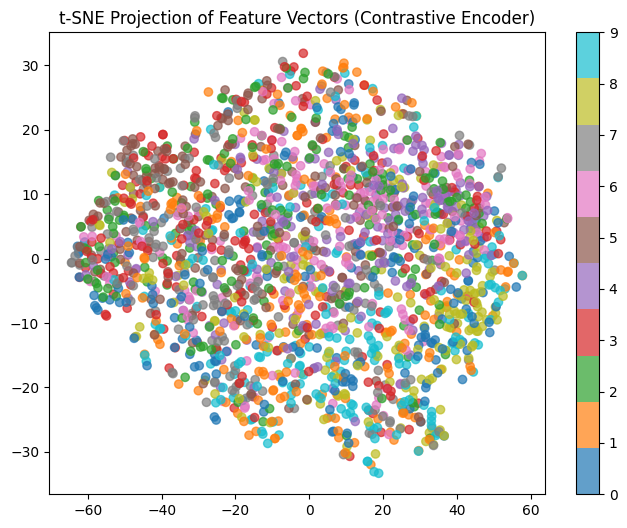

In [10]:
# ###  Step 9: Use t-SNE to visualize learned representations
features = encoder.predict(x_test)
tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE Projection of Feature Vectors (Contrastive Encoder)")
plt.show()
